In [1]:
import getdata
import pickle
import numpy as np 
import network
import matplotlib.pyplot as plt
import scipy.ndimage
import cv2
import os
from keras.models import model_from_json, Model
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
# load data
flatten = False      # Get 1D data
rescale = True       #  Rescale 'RGB' values from [0,255] to [1,0]
denoise_only = False # Reshape target values from 128x128 to 64x64
amount = 0        # Amount of data to load, 0 gives loads all data
train_x, train_y = getdata.get_training(flatten = flatten, rescale = rescale, amount = amount, denoise_only = denoise_only)
test_data, rng = getdata.get_test(flatten = flatten, rescale = rescale, denoise_only = denoise_only, amount = amount if amount < 4000 else 3999) 

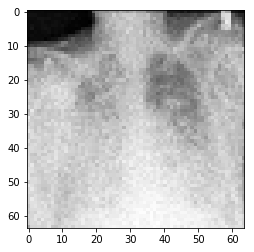

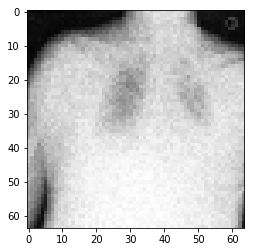

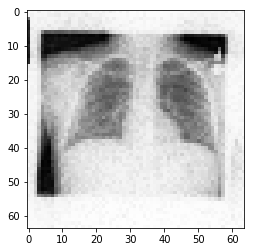

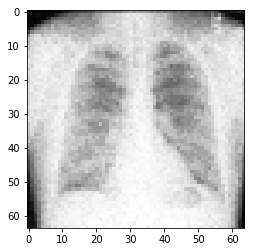

In [3]:
# show 2D images, must type in which data to show
n=0
for data in train_x[n:n+4]:
    data = data[:,:,0]
    plt.imshow(data, cmap = 'Greys')
    plt.show()

In [4]:
# define model

filters_64  = [(64,64,1),(16,3),(16,3)] # [(INPUT_SHAPE),(num_filters, kernel_size)...]
deconv      = (16,3) # (num_filters, kernel_size)
filters_128 = [(16,3),(16,3),(1,3)] #[(num_filters, kernel_size)...]

'''
filters_64  = [(64,64,1),(4,3)] # [(INPUT_SHAPE),(num_filters, kernel_size)...]
deconv      = (4,3) # (num_filters, kernel_size)
filters_128 = [(4,3),(1,3)] #[(num_filters, kernel_size)...]


'''
net = network.Network(filters_64, deconv, filters_128, test = 4)
net.network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 16)   2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, 64, 64, 16)   0           conv2d_2[0][0]                   
                                                                 input_1[0][0]                    
__________

In [5]:
# DEFINE CALLBACKS
callback = [TensorBoard(log_dir='./logs/run5',write_graph=False)]

In [ ]:
# TRAIN THE AUTOENCODER NORMALLY
net.train(train_x,train_y, epochs = 8, verbose = 1, \
          loss = 'mean_squared_error', optimizer= 'adadelta', \
          batch_size = 16, callback = callback)

Epoch 1/8
 7648/16000 [=============>................] - ETA: 8:32 - loss: 0.0057

In [ ]:
# TRAIN THE AUTOENCODER ALTERNATINGLY
losses = {True: 'mean_squared_error', False: 'mean_absolute_error'}
loss_ = False
for _ in range(7):
    net.train(train_x,train_y, epochs = 4, verbose = 1, \
          loss = losses[loss_], optimizer= 'adadelta', batch_size = 16)
    loss_ = not loss_

In [ ]:
# Test on 2D data
num = 4 # image number [1..5]

# Load and show input image
user_array = scipy.ndimage.imread('x' + str(num) + '.png', flatten=True, mode=None)
user_array = 1-(user_array/225)
print(user_array)
imgplot = plt.imshow(user_array, cmap = 'Greys', vmin = 0, vmax = 1)
plt.show()
# Load and show target image
flatten = True
target = scipy.ndimage.imread('y'+ str(num) + '.png', flatten=flatten, mode=None)
if flatten:
    target = 1-(target/225)
if denoise_only:
    target = cv2.resize(target,(64,64))
imgplot = plt.imshow(target, cmap = 'Greys', vmin = 0, vmax = 1)
plt.show()
# Compute and show output image
input_vector = np.expand_dims(user_array, axis = 3)
output_vector = net.predict(np.array([input_vector, input_vector]))[0]
output_array = output_vector[:,:,0]
imgplot = plt.imshow(output_array, cmap = 'Greys', vmin = 0, vmax = 1)
plt.show()

In [ ]:
amount_ = 5

inputs, targets = getdata.get_training(amount = amount_, flatten = False, rescale = True, denoise_only = False)

# show inputs
plt.figure(figsize=(3*amount_, 6))
for i in range(amount_):
    ax = plt.subplot(2, amount_, i + 1)
    plt.imshow(np.squeeze(inputs[i],2), cmap = 'Greys', vmin = 0, vmax = 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# show targets
plt.figure(figsize=(3*amount_, 6))
for i in range(amount_):
    ax = plt.subplot(2, amount_, i + 1)
    plt.imshow(np.squeeze(targets[i],2), cmap = 'Greys', vmin = 0, vmax = 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# show net output
outputs = net.predict(inputs)
plt.figure(figsize=(3*amount_, 6))
for i in range(amount_):
    ax = plt.subplot(2, amount_, i + 1)
    plt.imshow(np.squeeze(outputs[i],2), cmap = 'Greys', vmin = 0, vmax = 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
amount_ = 6
sample = 50
tests = getdata.get_test(flatten = False, rescale = True, amount = amount_, sample = sample) 

# show testinputs
plt.figure(figsize=(3*amount_, 6))
for i in range(amount_):
    ax = plt.subplot(2, amount_, i + 1)
    plt.imshow(np.squeeze(tests[i],2), cmap = 'Greys', vmin = 0, vmax = 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# show net output
outputs = net.predict(tests)
plt.figure(figsize=(3*amount_, 6))
for i in range(amount_):
    ax = plt.subplot(2, amount_, i + 1)
    plt.imshow(np.squeeze(outputs[i],2), cmap = 'Greys', vmin = 0, vmax = 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# SAVE MODEL

model_name = 'deepresdeconv4.5'

# save weights
save_path = os.getcwd() + '/model_weights/'+ model_name +'_weights.h5'
net.network.save_weights(save_path)
# save architecture in JSON
with open(os.getcwd() + '/model_weights/'+ model_name +'_architecture.json', 'w') as f:
    f.write(net.network.to_json())

In [ ]:
# Load Model

model_name = 'deepresdeconv4.5'

# model reconstruction from JSON
net = network.Network(None, None, None, test = 0)
with open(os.getcwd() + '/model_weights/'+ model_name +'_architecture.json', 'r') as f:
    net.network = model_from_json(f.read())
# load weights into the model
net.network.load_weights(os.getcwd() + '/model_weights/'+ model_name +'_weights.h5')

net.network.summary()